In [160]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import StratifiedKFold

# read data
train_df = pd.read_csv('../data/train.csv')
meal_df = pd.read_csv('../data/meal_info.csv')
fufil_df = pd.read_csv('../data/fulfilment_center_info.csv')
test_df = pd.read_csv('../data/test_QoiMO9B.csv')
sub_df = pd.read_csv('../data/sample_submission_hSlSoT6.csv')

# concat train and test dataframes
trn_size, tst_size = train_df.shape[0], test_df.shape[0]
df = pd.concat([train_df, test_df], axis=0, sort=False)

# join dataframes
df = pd.merge(df, meal_df, on='meal_id', how='left')
df = pd.merge(df, fufil_df, on='center_id', how='left')

# category encoding
df['category'] = df['category'].astype('category').cat.codes
df['cuisine'] = df['cuisine'].astype('category').cat.codes
df['city_code'] = df['city_code'].astype('category').cat.codes
df['center_type'] = df['center_type'].astype('category').cat.codes


# group function
def group_feature(df, col, feature, agg):
    feature_name = '_'.join(col) + '_{}_{}'.format(feature, agg)
    gp = df.groupby(col)[feature].agg(agg).reset_index().rename(columns={feature:feature_name})
    df = pd.merge(df, gp, on=col, how='left')
    
    df['{}_ratio'.format(feature_name)] = df[feature] / df[feature_name]
    df['{}_ratio'.format(feature_name)] = df['{}_ratio'.format(feature_name)].fillna(1.0)
#     df = df.drop(feature_name, axis=1)
    
    return df

# prices
cols = [['meal_id'], ['region_code', 'category', 'cuisine'], 
        ['center_id'], ['region_code'], ['center_id', 'meal_id'], ['region_code', 'meal_id']]
features = ['checkout_price', 'base_price']
for feature in features:
    for col in cols:
        df = group_feature(df, col, feature, 'mean')

# promotion
df['promotion'] = df['emailer_for_promotion'] + df['homepage_featured']

cols = [['meal_id'], ['center_id'], ['region_code'], ['region_code', 'category', 'cuisine']]
features = ['promotion']
for feature in features:
    for col in cols:
        df = group_feature(df, col, feature, 'sum')

# category comble features
cols = [['city_code'], ['center_id'], ['region_code']]
features = ['category', 'cuisine']
for feature in features:
    for col in cols:
        df = group_feature(df, col, feature, 'nunique')

cols = [['city_code'], ['region_code']]
features = ['center_type', 'meal_id']
for feature in features:
    for col in cols:
        df = group_feature(df, col, feature, 'nunique')
        

def history_feature(df, col, feature, agg):
    history_df = pd.DataFrame()
    feature_name = '_'.join(col) + '_{}'.format(feature)
    feature_name = '{}_history_{}'.format(feature_name, agg)
     
    for wk in range(1+df.week.max()+1):
        wk_df = df.loc[df.week<wk, :]
        
        history_gp = wk_df.groupby(col)[feature].agg(agg).reset_index() \
                          .rename(columns={feature:feature_name})
        
        history_gp['week'] = wk
        history_df = pd.concat([history_df, history_gp], axis=0)
        
    df = pd.merge(df, history_df, on=col+['week'], how='left')
    
    # fill with mean
    feature_mean_name = '{}_mean'.format(feature)
    mean_gp = df.groupby(col)[feature].agg(agg).reset_index().rename(columns={feature:feature_mean_name})
    df = pd.merge(df, mean_gp, on=col, how='left')
    df[feature_name] = df[feature_name].fillna(df[feature_mean_name])
    df = df.drop(feature_mean_name, axis=1)
    
    return df, feature_name

# target history
cols = [['center_id'], ['region_code', 'center_type', 'category'], ['city_code', 'cuisine'], 
        ['center_id', 'meal_id'], ['region_code', 'meal_id']]
features = ['num_orders']
feature_names = []
for feature in features:
    for col in cols:
        df, feature_name = history_feature(df, col, feature, 'mean')
        feature_names.append(feature_name)

# group comparing
combinations = []
for feature1 in feature_names:
    for feature2 in feature_names:
        if feature1 != feature2 and '{}_{}'.format(feature1, feature2) not in combinations and '{}_{}'.format(feature2, feature1) not in combinations:
            df['{}_{}_ratio'.format(feature1, feature2)] = df[feature1] / df[feature2]
            combinations.append('{}_{}'.format(feature1, feature2))


def diff_feature(df, col, feature):
    feature_name = '_'.join(col) + '_{}_diff'.format(feature)
    gp = df.groupby(col)[feature].mean()
    
    orig_df = gp.reset_index().rename(columns={feature: feature_name.replace('diff', 'orig')})
    # prevent overfitting
    if feature == 'num_orders':
        diff_df = gp.groupby(level=[i for i in range(len(col)-1)]).diff(1).shift(1).reset_index().rename(columns={feature: feature_name})
    else:    
        diff_df = gp.groupby(level=[i for i in range(len(col)-1)]).diff(1).reset_index().rename(columns={feature: feature_name})
    
    df = pd.merge(df, orig_df, on=col, how='left')
    df = pd.merge(df, diff_df, on=col, how='left')
    
    feature_discount_name = feature_name.replace('diff', 'discount')
    df[feature_discount_name] = df[feature_name] / df[feature_name.replace('diff', 'orig')]
    df[feature_discount_name] = df[feature_discount_name].apply(lambda x: 0.0 if x<0.1 else x)
    
    # fill na with mean
    feature_discount_mean_name = '{}_mean'.format(feature_discount_name)
    mean_col = [x for x in col if x != 'week']
    mean_df = df.groupby(mean_col)[feature_discount_name].mean().reset_index().rename(columns={feature_discount_name:feature_discount_mean_name})
    df = pd.merge(df, mean_df, on=mean_col, how='left')
    
    df[feature_discount_name] = df[feature_discount_name].fillna(df[feature_discount_mean_name])
    df = df.drop([feature_name, feature_name.replace('diff', 'orig'), feature_discount_mean_name], axis=1)
    
    return df

cols = [['center_id', 'category', 'week'], ['region_code', 'meal_id', 'week'], ['center_id', 'meal_id', 'week']]
features = ['checkout_price']
for feature in features:
    for col in cols:
        df = diff_feature(df, col, feature)

# save temp feature
# df.to_csv('../data/df_feature.csv', index=None)

# split dataset
train_da, valid_da, test_da = df.loc[df.week<136, :], df.loc[(df.week>=136)&(df.week<=145), :], df.loc[df.week>145, :]

ignorecols = ['id', 'num_orders', 'week']
features = [col for col in df.columns.tolist() if col not in ignorecols]

train_lgb = lgb.Dataset(train_da[features], train_da.num_orders.map(np.log1p))
valid_lgb = lgb.Dataset(valid_da[features], valid_da.num_orders.map(np.log1p))

params={
        'boosting':'gbdt',
        'objective':'regression_l2',
        'metric':'rmse',
        'learning_rate':0.1,
        'max_depth':6,
        'num_leaves':64,
        'bagging_fraction':0.7,
        'feature_fraction':0.7,
        'bagging_freq':4,
        'lambda_l2':3.0,
        'num_threads':4,
        'zero_as_missing':True,
        'seed':731
       }

lgb_train = lgb.train(params, 
                      train_set=train_lgb, 
                      num_boost_round=2000, 
                      valid_sets=[train_lgb, valid_lgb], 
                      valid_names=['train', 'valid'],
                      early_stopping_rounds=50, 
                      verbose_eval=10)

Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 0.659071	valid's rmse: 0.641365
[20]	train's rmse: 0.538387	valid's rmse: 0.534912
[30]	train's rmse: 0.513038	valid's rmse: 0.514146
[40]	train's rmse: 0.504705	valid's rmse: 0.50708
[50]	train's rmse: 0.500094	valid's rmse: 0.504451
[60]	train's rmse: 0.497126	valid's rmse: 0.502523
[70]	train's rmse: 0.495137	valid's rmse: 0.501407
[80]	train's rmse: 0.493043	valid's rmse: 0.500295
[90]	train's rmse: 0.491106	valid's rmse: 0.499331
[100]	train's rmse: 0.489402	valid's rmse: 0.498341
[110]	train's rmse: 0.487546	valid's rmse: 0.497532
[120]	train's rmse: 0.4863	valid's rmse: 0.497083
[130]	train's rmse: 0.485057	valid's rmse: 0.496329
[140]	train's rmse: 0.483431	valid's rmse: 0.495928
[150]	train's rmse: 0.482104	valid's rmse: 0.495338
[160]	train's rmse: 0.480937	valid's rmse: 0.494435
[170]	train's rmse: 0.47987	valid's rmse: 0.494136
[180]	train's rmse: 0.478865	valid's rmse: 0.493931
[190]	train's r

In [145]:
df.to_csv('../data/df_feature.csv', index=None)

In [139]:
params={
        'boosting':'gbdt',
        'objective':'regression_l2',
        'metric':'rmse',
        'learning_rate':0.1,
        'max_depth':6,
        'num_leaves':64,
        'bagging_fraction':0.7,
        'feature_fraction':0.7,
        'bagging_freq':4,
        'lambda_l2':3.0,
        'num_threads':4,
        'zero_as_missing':True,
        'seed':731
       }

lgb_train = lgb.train(params, 
                      train_set=train_lgb, 
                      num_boost_round=2000, 
                      valid_sets=[train_lgb, valid_lgb], 
                      valid_names=['train', 'valid'],
                      early_stopping_rounds=50, 
                      verbose_eval=10)

Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 0.665104	valid's rmse: 0.645416
[20]	train's rmse: 0.540794	valid's rmse: 0.5371
[30]	train's rmse: 0.513814	valid's rmse: 0.514622
[40]	train's rmse: 0.505161	valid's rmse: 0.507903
[50]	train's rmse: 0.500548	valid's rmse: 0.506028
[60]	train's rmse: 0.497591	valid's rmse: 0.504288
[70]	train's rmse: 0.495419	valid's rmse: 0.502965
[80]	train's rmse: 0.493277	valid's rmse: 0.502328
[90]	train's rmse: 0.491336	valid's rmse: 0.500894
[100]	train's rmse: 0.489684	valid's rmse: 0.500265
[110]	train's rmse: 0.488169	valid's rmse: 0.499562
[120]	train's rmse: 0.486762	valid's rmse: 0.498652
[130]	train's rmse: 0.485312	valid's rmse: 0.497712
[140]	train's rmse: 0.483843	valid's rmse: 0.497232
[150]	train's rmse: 0.482491	valid's rmse: 0.496692
[160]	train's rmse: 0.481193	valid's rmse: 0.496028
[170]	train's rmse: 0.480212	valid's rmse: 0.495434
[180]	train's rmse: 0.479122	valid's rmse: 0.494442
[190]	train's

<Figure size 864x432 with 0 Axes>

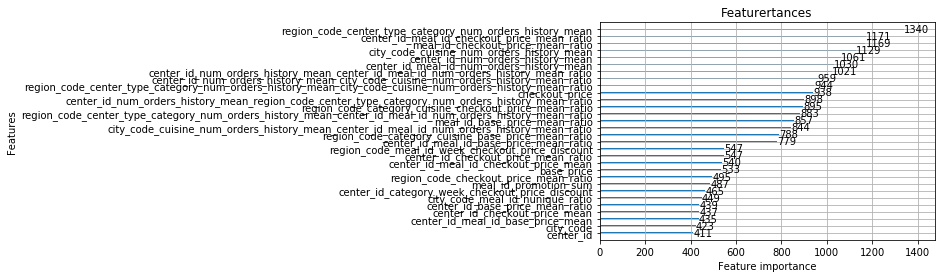

In [123]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
lgb.plot_importance(lgb_train, max_num_features=30)
plt.title("Featurertances")
plt.show()

In [96]:
test_da.region_code_meal_id_week_checkout_price_discount.describe()

count    32573.000000
mean         0.012750
std          0.057510
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.800018
Name: region_code_meal_id_week_checkout_price_discount, dtype: float64

In [111]:
train_da.loc[(train_da.meal_id==1885)&(train_da.center_id==55),:]

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,...,center_id_num_orders_history_mean,region_code_center_type_category_num_orders_history_mean,city_code_cuisine_num_orders_history_mean,center_id_num_orders_history_mean_region_code_center_type_category_num_orders_history_mean_ratio,center_id_num_orders_history_mean_city_code_cuisine_num_orders_history_mean_ratio,region_code_center_type_category_num_orders_history_mean_city_code_cuisine_num_orders_history_mean_ratio,center_id_category_week_checkout_price_discount,region_code_meal_id_week_checkout_price_discount,center_id_category_week_num_orders_discount,region_code_meal_id_week_num_orders_discount
0,1379560,1,55,1885,136.83,152.29,0,0,177.0,0,...,163.475709,249.387867,279.324348,0.655508,0.585254,0.892825,0.013850,0.002673,0.119308,0.027792
2922,1018704,2,55,1885,135.83,152.29,0,0,323.0,0,...,254.000000,334.090909,261.904762,0.760272,0.969818,1.275620,0.000000,0.000000,0.119308,0.027792
5818,1196273,3,55,1885,132.92,133.92,0,0,96.0,0,...,229.846154,333.006494,261.581395,0.690215,0.878679,1.273051,0.000000,0.000000,0.000000,0.000000
8717,1116527,4,55,1885,135.86,134.86,0,0,163.0,0,...,205.618557,319.378261,269.903226,0.643809,0.761823,1.183307,0.000000,0.000000,0.000000,0.000000
11606,1343872,5,55,1885,146.50,147.50,0,0,215.0,0,...,205.914729,329.581169,280.476190,0.624777,0.734161,1.175077,0.000000,0.000000,0.608678,0.136126
14465,1493612,6,55,1885,146.53,146.53,0,0,285.0,0,...,223.131250,314.248705,280.714286,0.710047,0.794870,1.119461,0.124322,0.000000,0.000000,0.000000
17311,1110832,7,55,1885,145.53,146.53,0,0,148.0,0,...,217.077720,302.120350,282.937500,0.718514,0.767229,1.067799,0.000000,0.000000,0.000000,0.000000
20106,1461167,8,55,1885,146.53,145.53,0,0,135.0,0,...,214.054054,291.221374,278.112583,0.735022,0.769667,1.047135,0.000000,0.000000,0.538095,0.000000
22892,1102364,9,55,1885,134.83,134.83,0,0,175.0,0,...,203.808000,277.130872,277.258621,0.735421,0.735083,0.999539,0.000000,0.000000,0.000000,0.000000
25746,1018130,10,55,1885,144.56,143.56,0,0,175.0,0,...,199.282686,274.658754,280.734694,0.725565,0.709861,0.978357,0.000000,0.000000,0.670552,0.000000


In [156]:
train_da_all = df.loc[df.week<146, :]
best_iteration = lgb_train.best_iteration

In [113]:
train_da_all.shape, train_df.shape

((456548, 71), (456548, 9))

In [157]:
train_lgb_all = lgb.Dataset(train_da_all[features], train_da_all.num_orders.map(np.log1p))

lgb_train_all = lgb.train(params, 
                          train_set=train_lgb_all, 
                          num_boost_round=best_iteration)

predict = np.expm1(lgb_train_all.predict(test_da[features]))

In [98]:
# # time series ensemble
# predict = np.zeros(sub_df.shape[0])
# skf = StratifiedKFold(n_splits=5)
# for train_index, test_index in skf.split(train_da_all[features], train_da_all.week):
#     train_fold = train_da_all.loc[train_index, :]
#     train_lgb_fold = lgb.Dataset(train_fold[features], train_fold.num_orders.map(np.log1p))
    
#     lgb_train_fold = lgb.train(params,
#                                train_set=train_lgb_fold, 
#                                num_boost_round=best_iteration)
    
#     predict += lgb_train_fold.predict(test_da[features])

# predict /= 5.0
# predict = np.expm1(predict).astype(int)

In [158]:
sub_df['num_orders'] = predict

In [159]:
sub_df.to_csv('../sub/baseline_10.csv', index=None)
# 57.8 lb